# ASSIGNMENT 4-1

In [32]:
%matplotlib widget

In [33]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

import jax
import jax.numpy as jnp
import numpy as np

import haiku as hk
import gymnasium as gym
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from IPython.display import Video 

import warnings
warnings.filterwarnings('ignore')

In [34]:
#RiverSwim
class RiverSwim(gym.Env):
    
    def __init__(self, nState: int = 10, maxSteps: int = 100):
        """
        Initialize the RiverSwim environment.
        
        Args:
            nState: Number of states in the river
            maxSteps: Maximum steps per episode
        """
        super().__init__()
        self.n_states = nState
        self.action_space = gym.spaces.Discrete(2)  # 0: swim right, 1: swim left
        self.observation_space = gym.spaces.Discrete(nState)
        self.state = 0  # Starting position
        self.step_count = 0
        self.max_steps = maxSteps

    def reset(self, seed=None, options=None):
        """Reset environment to initial state."""
        super().reset(seed=seed)
        self.state = 0
        self.step_count = 0
        return self.state, {}  # Return state and empty info dict

    def step(self, action: int):
        """ Execute one environment step. """
        # State transition logic
        if action == 0:
            rand = self.np_random.random()
            
            if self.state == 0:  # First state
                next_state = 1 if rand < 0.9 else 0
            elif self.state == self.n_states - 1:
                next_state = self.n_states if rand < 0.95 else self.n_states - 1
            else:
                if rand < 0.9:
                    next_state = self.state + 1
                else:
                    next_state = self.state + self.np_random.choice([-1, 0])
        
        elif action == 1:
            next_state = max(0, self.state - 1)

        # Reward calculation
        if next_state == 0 and self.state == 0:
            reward = 0.5
        elif next_state == self.n_states-1 and self.state == self.n_states-1:
            reward = 1.0
        else:
            reward = 0.0

        # Episode termination check
        self.step_count += 1
        truncated = self.step_count >= self.max_steps
        terminated = False  # No natural termination, only truncation
        
        self.state = next_state
        return next_state, reward, terminated, truncated, {}


In [35]:
env = RiverSwim()

cwd = os.getcwd()
NUM_ACTION = env.action_space.n
NUM_STATE = env.observation_space.n

# Generate a random seed
rng = jax.random.PRNGKey(seed=10)
# Use the random seed to generate a sequence of random seeds
rngs = hk.PRNGSequence(rng)
# A new random seed is obtained by calling next(rngs)

## 1-a/b

### Definition of main useful functions

In [36]:
def policy_network(s: jnp.ndarray) -> jnp.ndarray:
    """Policy network."""
    return hk.Sequential([
        hk.Linear(NUM_ACTION, w_init=jnp.ones, with_bias=False), # Initialize weights to 1
        jax.nn.softmax  # Convert to probability distribution
    ])(s)

def value_network(s: jnp.ndarray) -> jnp.ndarray:
    """Value network."""
    return hk.Sequential([
        hk.Linear(1, w_init=jnp.zeros, with_bias=False), # Initialize weights to 0
        jnp.ravel  # Flatten to scalar
    ])(s)

pi_transformed = hk.without_apply_rng(hk.transform(policy_network)) # Transform policy network with Haiku
vf_transformed = hk.without_apply_rng(hk.transform(value_network))  # Transform value network with Haiku

@jax.jit
def get_action_probs(params: dict, state: jnp.ndarray) -> jnp.ndarray: 
    """Get action probabilities for given state."""
    return pi_transformed.apply(params, jax.nn.one_hot(state, NUM_STATE))

@jax.jit
def get_state_value(params: dict, state: jnp.ndarray) -> jnp.ndarray:
    """Get estimated value for given state."""
    return vf_transformed.apply(params, jax.nn.one_hot(state, NUM_STATE)).squeeze()

@jax.jit
def action_log_prob(params: dict, state: jnp.ndarray, action: jnp.ndarray) -> jnp.ndarray:
    """Calculate log probability of taking specific action in state."""
    probs = get_action_probs(params, state)
    return jnp.log(probs[action])

@jax.jit
def compute_advantage(v_params: dict, state: jnp.ndarray, return_: float) -> jnp.ndarray:
    """Compute advantage using value function baseline."""
    return return_ - get_state_value(v_params, state)

# Gradient functions
policy_grad = jax.grad(action_log_prob)
value_grad = jax.grad(get_state_value)

#%% Parameter Update Rules
@jax.jit
def update_policy(params: dict, grads: dict, lr: float, delta_: float) -> dict:
    """Update policy parameters using policy gradient theorem."""
    return jax.tree_map(lambda p, g: p + lr * delta_ * g, params, grads)

@jax.jit
def update_value(params: dict, grads: dict, lr: float, delta: float) -> dict:
    """Update value function parameters using TD error."""
    return jax.tree_map(lambda p, g: p + lr * delta * g, params, grads)


<img src="img/assign-4/reinforce-algo.png" alt="alt text" style="width:15cm;"/>

<img src="img/assign-4/reinforce-SAC-algo.png" alt="alt text" style="width:15cm;"/>

In [37]:
# REINFORCE Algorithm
def reinforce(
    pi_params: dict,
    vf_params: dict,
    rngs: hk.PRNGSequence,
    gamma: float = 0.99,
    pi_lr: float = 1e-4,
    vf_lr: float = 1e-3,
    episodes: int = 3000,
    env: gym.Env = RiverSwim(nState=10, maxSteps=100),
    algorithm:str ='reinforce_MC', #['reinforce_MC', 'reinforce_TD']
    use_baseline: bool = True
) -> tuple[dict, dict, list]:
    """
    REINFORCE algorithm with optional value function baseline.
    
    Args:
        pi_params: Initial policy parameters
        vf_params: Initial value function parameters
        rng: JAX random key
        gamma: Discount factor
        pi_lr: Policy learning rate
        vf_lr: Value function learning rate
        episodes: Number of training episodes
        env: Environment to train on
        use_baseline: Whether to use value function baseline
        
    Returns:
        tuple: (Final policy params, Final value params, Reward history)
    """
    reward_history = []
    
    pbar = tqdm(range(episodes))

    for _ in pbar:
        # Episode data collection
        episode_data = []
        state, _ = env.reset()
        
        # Generate trajectory
        while True:
            # Get action probabilities and sample action
            action_probs = get_action_probs(pi_params, state)
            action = jax.random.choice(next(rngs), NUM_ACTION, p=action_probs)
            
            # Step environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Store transition
            episode_data.append((state, action, reward, next_state, done))
            
            if algorithm == 'reinforce_TD':
                # Get state and next state values
                state_value = get_state_value(vf_params, state)
                next_state_value = get_state_value(vf_params, next_state) if not done else 0.0
                
                # TD-error - advantage
                advantage = reward + gamma * next_state_value - state_value
                
                # Gradient calculation
                pi_grad = policy_grad(pi_params, state, action)
                vf_grad = value_grad(vf_params, state)
                
                # Update parameters
                pi_params = update_policy(pi_params, pi_grad, pi_lr, advantage)
                vf_params = update_value(vf_params, vf_grad, vf_lr, advantage)
            
            if done:
                break
            state = next_state

        if algorithm == 'reinforce_MC':
            # Calculate discounted returns
            states, actions, rewards, _, _ = zip(*episode_data)
            
            returns = []
            ret = 0.0
            for r in reversed(rewards):
                ret = r + gamma * ret
                returns.insert(0, ret)
            
            # Convert to JAX arrays
            states = jnp.array(states)
            actions = jnp.array(actions)
            returns = jnp.array(returns)

            # Update parameters for each step in episode
            for s, a, ret in zip(states, actions, returns):
                # Calculate gradients
                pi_grad = policy_grad(pi_params, s, a)
                
                if use_baseline:
                    # Calculate advantage and value gradient
                    delta = compute_advantage(vf_params, s, ret)
                    vf_grad = value_grad(vf_params, s)
                    
                    # Update parameters
                    pi_params = update_policy(pi_params, pi_grad, pi_lr, delta)
                    vf_params = update_value(vf_params, vf_grad, vf_lr, delta)
                else:
                    # Update without baseline
                    pi_params = update_policy(pi_params, pi_grad, pi_lr, ret)

        # Record episode performance
        rewards_ep =(sum(r for _, _, r, _, _ in episode_data))
        reward_history.append(rewards_ep)
        pbar.set_description(f"Episode Reward: {rewards_ep}")

    return pi_params, vf_params, reward_history

Tests of the following algorithms:

- REINFORCE with Monte Carlo algorithm without baseline
- REINFORCE with Monte Carlo algorithm without baseline
- REINFORCE with Temporal Difference (0) algorithm

Parameters:

gamma: float = 0.99  
pi_lr: float = 1e-4  
vf_lr: float = 1e-3  
episodes: int = 3000  
env: gym.Env = RiverSwim(nState=10, maxSteps=100)  

In [38]:
# Initialize networks
dummy_input = jax.nn.one_hot(0, NUM_STATE)  # One-hot encoded state

# Initialize parameters
pi_params_0 = pi_transformed.init(rng, dummy_input)
vf_params_0 = vf_transformed.init(rng, dummy_input)

pi_params = pi_params_0
vf_params = vf_params_0


# RUN TRAINING
MC_pi, MC_vf, MC_rewards = reinforce(pi_params=pi_params_0, vf_params=vf_params_0, algorithm='reinforce_MC', use_baseline=False, rngs=rngs,) # Run training without baseline - MC

MC_pi_A, MC_vf1, MC_rewards_A = reinforce(pi_params=pi_params_0, vf_params=vf_params_0,  algorithm='reinforce_MC', use_baseline=True, rngs=rngs,) # Run training with baseline - MC

TD_pi, TD_vf, TD_rewards = reinforce(pi_params=pi_params_0, vf_params=vf_params_0, algorithm='reinforce_TD', use_baseline=False, rngs=rngs,) # Run training without baseline - TD(0)

  0%|          | 0/3000 [00:00<?, ?it/s]

Episode Reward: 49.0: 100%|██████████| 3000/3000 [14:55<00:00,  3.35it/s]


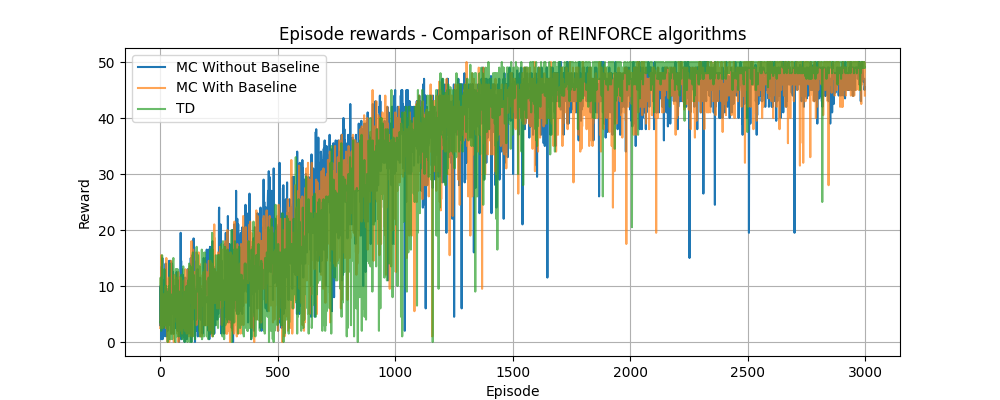

In [39]:
plt.figure(figsize=(10, 4))
plt.plot(MC_rewards, label='MC Without Baseline', alpha=1)
plt.plot(MC_rewards_A, label='MC With Baseline', alpha=0.7)
plt.plot(TD_rewards, label='TD', alpha=0.7)
plt.legend()
plt.grid()
plt.title("Episode rewards - Comparison of REINFORCE algorithms")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

In [ ]:
print("Final Policy Parameters:", MC_pi)
print("Final Value Function Parameters:", MC_vf)
print("Final Policy Parameters with Baseline:", MC_pi_A)
print("Final Value Function Parameters with Baseline:", MC_vf1)
print("Final Policy Parameters TD:", TD_pi)
print("Final Value Function Parameters TD:", TD_vf)

# jnp.savez(
#     os.path.join(cwd, "saved_models", "3", "model_params_MC.npz"),
#     policy_params=jax.device_get(MC_pi),
#     value_params=jax.device_get(MC_vf)
# )
# jnp.savez(
#     os.path.join(cwd, "saved_models", "3", "model_params_MC_A.npz"),
#     policy_params=jax.device_get(MC_pi_A),
#     value_params=jax.device_get(MC_vf1)
# )  
# jnp.savez(
#     os.path.join(cwd, "saved_models", "3", "model_params_TD.npz"),
#     policy_params=jax.device_get(TD_pi),
#     value_params=jax.device_get(TD_vf)
# )


Final Policy Parameters: {'linear': {'w': Array([[-0.7987052 ,  2.7986326 ],
       [ 0.18867059,  1.8113247 ],
       [ 0.52805614,  1.4719396 ],
       [ 0.73756427,  1.262444  ],
       [ 0.8595632 ,  1.140433  ],
       [ 0.91518056,  1.0848191 ],
       [ 0.9505496 ,  1.0494534 ],
       [ 0.974697  ,  1.0253016 ],
       [ 0.9818811 ,  1.0181202 ],
       [ 0.989441  ,  1.0105596 ]], dtype=float32)}}
Final Value Function Parameters: {'linear': {'w': Array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)}}
Final Policy Parameters with Baseline: {'linear': {'w': Array([[-0.9044956 ,  2.9045181 ],
       [ 0.22250935,  1.7775047 ],
       [ 0.5449359 ,  1.4550663 ],
       [ 0.7331808 ,  1.2668209 ],
       [ 0.8582089 ,  1.1417947 ],
       [ 0.906278  ,  1.0937217 ],
       [ 0.9434768 ,  1.0565206 ],
       [ 0.96236837,  1.0376306 ],
       [ 0.97655505,  1.0234472 ],
       [ 0.9940925 , 

## 1-c

In [40]:
def biased_policy_network(s: jnp.ndarray) -> jnp.ndarray:
    """Policy network con inizializzazione che favorisce a=1."""
    return hk.Sequential([
        hk.Linear(NUM_ACTION, w_init=hk.initializers.Constant([[0., 1.]] * (NUM_STATE)), with_bias=False),
        jax.nn.softmax
    ])(s)

pi_biased_nn = hk.without_apply_rng(hk.transform(biased_policy_network))
pi_biased_params = pi_biased_nn.init(rng, dummy_input)
probs = pi_biased_nn.apply(pi_biased_params, dummy_input)

print("Biased policy parameters:", pi_biased_params)
print("Biased policy probabilities:", probs)


Biased policy parameters: {'linear': {'w': Array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)}}
Biased policy probabilities: [0.26894143 0.73105854]


Tests of the following algorithms:

- REINFORCE with Temporal Difference (0) algorithm with a initial biased policy

Parameters:

gamma: float = 0.99  
pi_lr: float = 1e-4  
vf_lr: float = 1e-2 
episodes: int = 3000  
env: gym.Env = RiverSwim(nState=10, maxSteps=100)  

In [41]:
# RUN TRAINING
#bMC_pi, bMC_vf, bMC_rewards = reinforce(pi_params=pi_biased_params, vf_params=vf_params_0, algorithm='reinforce_MC', use_baseline=False, rngs=rngs,) # Run training without baseline - MC

#bMC_pi_A, bMC_vf1, bMC_rewards_A = reinforce(pi_params=pi_biased_params, vf_params=vf_params_0,  algorithm='reinforce_MC', use_baseline=True, rngs=rngs,) # Run training with baseline - MC

bTD_pi, bTD_vf, bTD_rewards = reinforce(pi_params=pi_biased_params, vf_params=vf_params_0, vf_lr=1e-2, algorithm='reinforce_TD', use_baseline=False, rngs=rngs,) # Run training without baseline - TD(0)

Episode Reward: 49.0: 100%|██████████| 3000/3000 [14:07<00:00,  3.54it/s]


In [ ]:
print("Final Policy Parameters TD:", bTD_pi)
print("Final Value Function Parameters TD:", bTD_vf)

# jnp.savez(
#     os.path.join(cwd, "saved_models", "3", "model_params_bTD.npz"),
#     policy_params=jax.device_get(bTD_pi),
#     value_params=jax.device_get(bTD_vf)
# )

Final Policy Parameters TD: {'linear': {'w': Array([[-1.5902981e+00,  2.5925169e+00],
       [-5.9437460e-01,  1.5943674e+00],
       [-2.8017241e-01,  1.2801739e+00],
       [-9.7307727e-02,  1.0973067e+00],
       [-1.6548077e-02,  1.0165480e+00],
       [-1.3257497e-03,  1.0013256e+00],
       [-5.6951270e-05,  1.0000572e+00],
       [-4.6326798e-07,  1.0000005e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00]], dtype=float32)}}
Final Value Function Parameters TD: {'linear': {'w': Array([[2.39551888e+01],
       [2.35773621e+01],
       [2.10656166e+01],
       [1.54167595e+01],
       [5.23113108e+00],
       [4.13265198e-01],
       [2.08810009e-02],
       [1.72256085e-04],
       [0.00000000e+00],
       [0.00000000e+00]], dtype=float32)}}


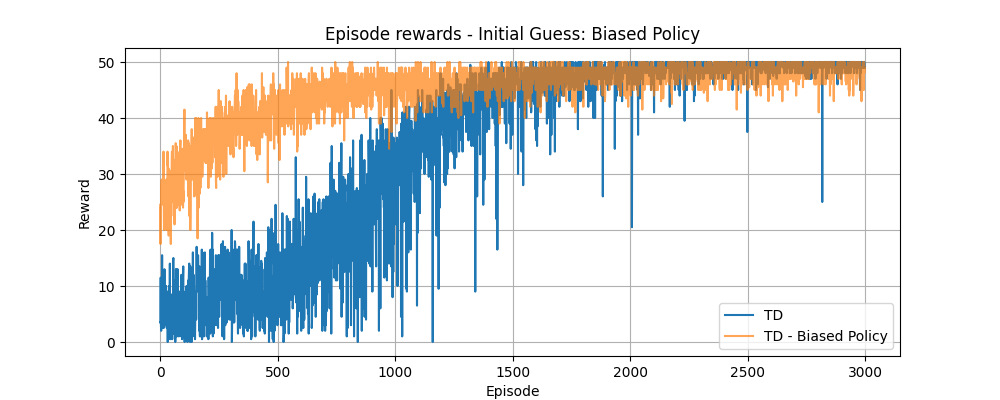

In [43]:
plt.figure(figsize=(10, 4))
#plt.plot(bMC_rewards, label='MC Without Baseline', alpha=1)
#plt.plot(bMC_rewards_A, label='MC With Baseline', alpha=0.7)
plt.plot(TD_rewards, label='TD', alpha=1)
plt.plot(bTD_rewards, label='TD - Biased Policy', alpha=0.7)
plt.legend()
plt.grid()
plt.title("Episode rewards - Initial Guess: Biased Policy")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

## 1-d

Tests of the following algorithms:

- REINFORCE with Temporal Difference (0) algorithm with reduced number of states (5)

Parameters:

gamma: float = 0.99  
pi_lr: float = 1e-4  
vf_lr: float = 1e-2 
episodes: int = 3000  
env: gym.Env = RiverSwim(nState=5, maxSteps=100)  

In [45]:
# RUN TRAINING - Less number of states
sTD_pi, sTD_vf, sTD_rewards = reinforce(env=RiverSwim(nState=5),pi_params=pi_params_0, vf_params=vf_params_0, vf_lr=1e-2, algorithm='reinforce_TD', use_baseline=False, rngs=rngs,) # Run training without baseline - TD(0)

Episode Reward: 48.0: 100%|██████████| 3000/3000 [12:38<00:00,  3.95it/s]


In [ ]:
print("Final Policy Parameters TD:", sTD_pi)
print("Final Value Function Parameters TD:", sTD_vf)

# jnp.savez(
#     os.path.join(cwd, "saved_models", "3", "model_params_sTD.npz"),
#     policy_params=jax.device_get(sTD_pi),
#     value_params=jax.device_get(sTD_vf)
# )

Final Policy Parameters TD: {'linear': {'w': Array([[-1.0220095 ,  3.0212414 ],
       [ 0.02221017,  1.9777961 ],
       [ 0.4300092 ,  1.5699854 ],
       [ 0.6839313 ,  1.3160721 ],
       [ 0.8216303 ,  1.1783668 ],
       [ 0.9093107 ,  1.0906936 ],
       [ 0.95318854,  1.0468098 ],
       [ 0.9786159 ,  1.0213817 ],
       [ 0.990945  ,  1.0090531 ],
       [ 0.99602497,  1.0039722 ]], dtype=float32)}}
Final Value Function Parameters TD: {'linear': {'w': Array([[23.891203  ],
       [23.319004  ],
       [20.607828  ],
       [15.312765  ],
       [ 8.558744  ],
       [ 5.123875  ],
       [ 2.5139983 ],
       [ 1.3511088 ],
       [ 0.66624004],
       [ 0.27392623]], dtype=float32)}}


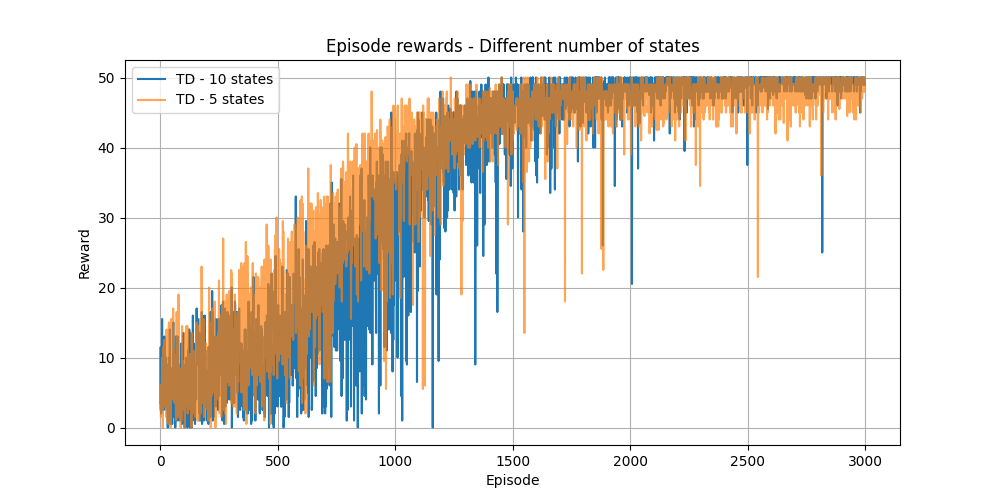

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(TD_rewards, label='TD - 10 states', alpha=1)
plt.plot(sTD_rewards, label='TD - 5 states', alpha=0.7)
plt.legend()
plt.grid()
plt.title("Episode rewards - Different number of states")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()